In [1]:
import xarray as xr
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import iris

In [2]:
# Define dictionaries for the scenarios
scenarios = {
    'expt1': 'pa-pdSIC-ext',
    'expt2': 'pa-futArcSIC-ext',
    'expt3': 'pa-futAntSIC-ext',
    'expt4': 'pa-pdSIC-2XCO2-ext',
    'expt5': 'pa-futSIC-2XCO2-ext'
}

In [3]:
# Define a function to calculate transport (pr* - qflx*)
def calculate_transport(pr, qflx):
    return pr - qflx

# Create file paths for qflx and pr datasets
qflx_files = {key: f"/scratch/lvillanu/data/{value}_qflx_mean_each_month.nc" for key, value in scenarios.items()}
pr_files = {key: f"/scratch/lvillanu/data/{value}_pr_mean_each_month.nc" for key, value in scenarios.items()}

In [20]:
prc_files = {key: f"/scratch/lvillanu/data/{value}_prc_mean_each_month.nc" for key, value in scenarios.items()}

In [21]:
# Load qflx datasets
qflx_datasets = {key: iris.load(filepath)[0] for key, filepath in qflx_files.items()}

# Load pr datasets
pr_datasets = {key: iris.load(filepath)[0] for key, filepath in pr_files.items()}

prc_datasets = {key: iris.load(filepath)[0] for key, filepath in prc_files.items()}

# Define function to convert units to mm/day
def convert_to_mm_per_day(cube):
    if cube.units == 'm/s':
        # Convert from meters per second to mm/day
        # There are 86400 seconds in a day, 1000 mm in a meter
        conversion_factor = 86400 * 1000
        cube.data = cube.data * conversion_factor
        cube.units = 'mm/day'
    elif cube.units == 'kg/m2/s':
        # Convert from meters per month to mm/day
        # Average month length: 30.44 days
        conversion_factor = 86400
        cube.data = cube.data * conversion_factor
        cube.units = 'mm/day'
    elif cube.units != 'mm/day':
        raise ValueError(f"Unexpected units: {cube.units}")

    return cube

# Convert all datasets to mm/day
qflx_datasets_mm_day = {key: convert_to_mm_per_day(cube) for key, cube in qflx_datasets.items()}
pr_datasets_mm_day = {key: convert_to_mm_per_day(cube) for key, cube in pr_datasets.items()}
prc_datasets_mm_day = {key: convert_to_mm_per_day(cube) for key, cube in prc_datasets.items()}


# Define function to calculate transport
def calculate_transport(pr_cube, qflx_cube):
    # Ensure both cubes have the same dimensions and units
    if pr_cube.shape != qflx_cube.shape:
        raise ValueError("Dimension mismatch between pr and qflx cubes")
    
    # Calculate transport (pr - qflx)
    transport = pr_cube.copy()
    transport.data = pr_cube.data - qflx_cube.data
    transport.units = 'mm/day'
    return transport

# Calculate transport (pr* - qflx*)
transports = {key: calculate_transport(pr_datasets_mm_day[key], qflx_datasets_mm_day[key]) for key in scenarios.keys()}

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/iris/fileformats/_nc_load_rules/helpers.py:1178: _WarnComboDefaultingCfLoad: Failed to create 'time' dimension coordinate: The 'time' DimCoord points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  warnings.warn(


In [22]:
def extract_arctic(data_in):
    """
    Extracts the Arctic region (latitude from 70 to 90 degrees) from the input data.

    Parameters:
    data_in (iris.cube.Cube): Input data cube to be constrained.

    Returns:
    iris.cube.Cube: Data cube constrained to the Arctic region.
    """
    # Define a geographical constraint for the Arctic region
    R = iris.Constraint(latitude=lambda lat: 60 <= lat <= 90,
                        longitude=lambda lon: 0 <= lon <= 360)
    
    # Extract data within the defined constraint
    data_out = data_in.extract(R)
    
    return data_out

In [6]:
# Apply extraction function to all datasets
arctic_qflx_datasets = {key: extract_arctic(cube) for key, cube in qflx_datasets_mm_day.items()}
arctic_pr_datasets = {key: extract_arctic(cube) for key, cube in pr_datasets_mm_day.items()}
arctic_transport_datasets = {key: extract_arctic(cube) for key, cube in transports.items()}
arctic_prc_datasets = {key: extract_arctic(cube) for key, cube in pr_datasets_mm_day.items()}

In [7]:
def area_weighted(data_in):
    """
    Computes the area-weighted mean of the input data across latitude and longitude.

    Parameters:
    data_in (iris.cube.Cube): Input data cube to be averaged.

    Returns:
    iris.cube.Cube: Area-weighted mean of the input data.
    """
    # Guess bounds for latitude and longitude coordinates
    data_in.coord('latitude').guess_bounds()
    data_in.coord('longitude').guess_bounds()

    # Compute the area weights for each cell
    cell_area = iris.analysis.cartography.area_weights(data_in)

    # Compute the area-weighted mean across latitude and longitude
    data_out = data_in.collapsed(['latitude', 'longitude'],
                                 iris.analysis.MEAN,
                                 weights=cell_area)
    
    return data_out

In [8]:
# Example: Apply area_weighted to each dataset in qflx_datasets_mm_day and pr_datasets_mm_day
arctic_qflx_datasets_weighted = {key: area_weighted(cube) for key, cube in arctic_qflx_datasets.items()}
arctic_pr_datasets_weighted = {key: area_weighted(cube) for key, cube in arctic_pr_datasets.items()}
arctic_transport_datasets_weighted = {key: area_weighted(cube) for key, cube in arctic_transport_datasets.items()}

/home/netapp-clima/users/ggiulian/m20/lib/python3.10/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [9]:
arctic_qflx_datasets_weighted['expt5'].data

masked_array(data=[0.6023690666006828, 0.549489243470886,
                   0.5113226227621835, 0.4779609472929905,
                   0.465988306827698, 0.568597617296909,
                   0.8626708890853215, 0.9330613065504153,
                   0.7379986269970014, 0.660625708850141,
                   0.7032218303480599, 0.6527819151462039],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)

In [10]:
arctic_pr_datasets_weighted['expt5'].data

masked_array(data=[1.1568913722610896, 1.00640520197606,
                   0.9807037925238474, 0.9463121371033105,
                   0.944720151889062, 0.9688470210550202,
                   1.0847172767706523, 1.2734881189325726,
                   1.5084926968072883, 1.647942543700445,
                   1.5647935114455804, 1.3564584294229467],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)

In [11]:
arctic_transport_datasets_weighted['expt5'].data

masked_array(data=[0.5545223056604068, 0.45691595850517414,
                   0.469381169761664, 0.46835118981032015,
                   0.478731845061364, 0.40024940375811086,
                   0.222046387685331, 0.3404268123821573,
                   0.770494069810287, 0.9873168348503039,
                   0.8615716810975202, 0.7036765142767427],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert to DataFrame for easier plotting
def to_dataframe(weighted_qflx, weighted_transport):
    """
    Converts the dictionaries of weighted data into DataFrames.
    
    Parameters:
    weighted_qflx (dict): Dictionary with scenario names as keys and Iris cubes as values.
    weighted_transport (dict): Dictionary with scenario names as keys and Iris cubes as values.

    Returns:
    tuple: DataFrames for QFLX and Transport.
    """
    # Extract monthly means
    months = np.arange(1, 13)  # Assuming data is for 12 months
    df_qflx = pd.DataFrame({key: cube.data.flatten() for key, cube in weighted_qflx.items()}, index=months)
    df_transport = pd.DataFrame({key: cube.data.flatten() for key, cube in weighted_transport.items()}, index=months)
    
    return df_qflx, df_transport

# Prepare data
df_qflx, df_transport = to_dataframe(arctic_qflx_datasets_weighted, arctic_transport_datasets_weighted)

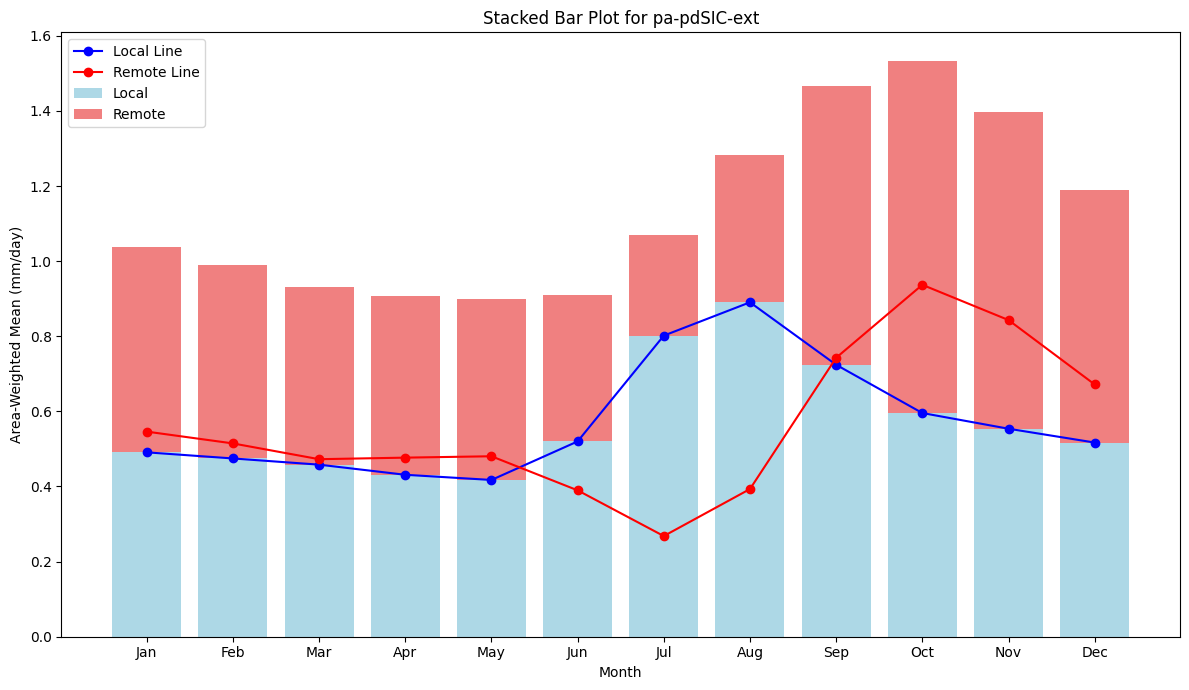

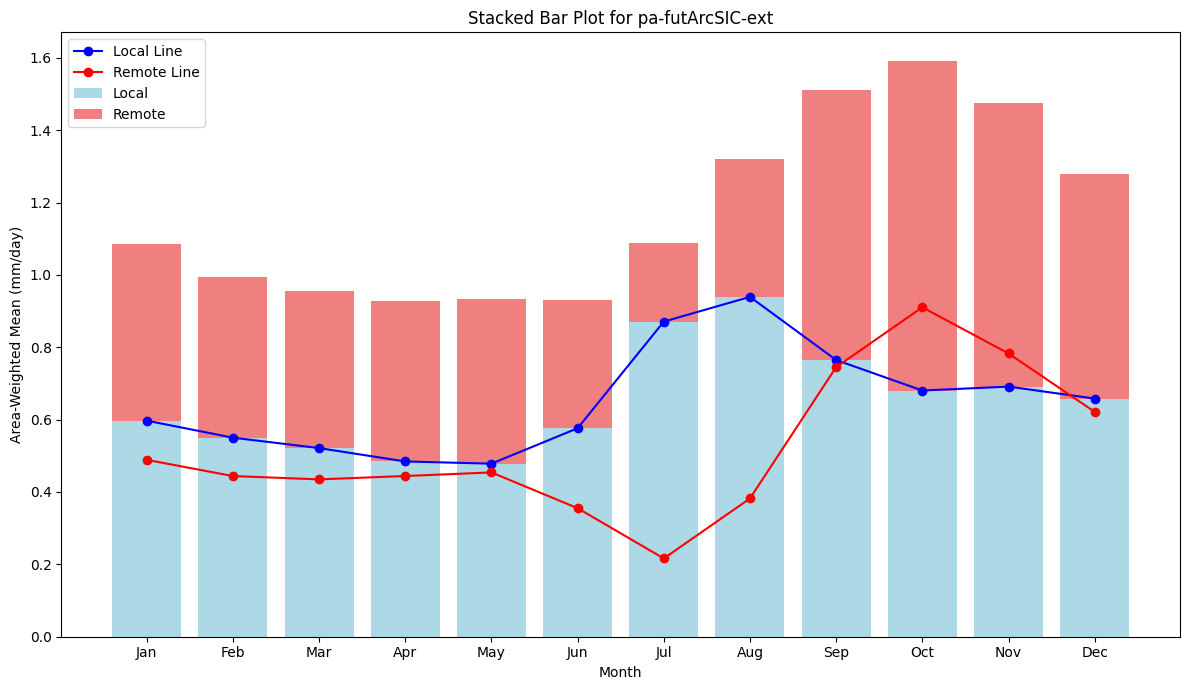

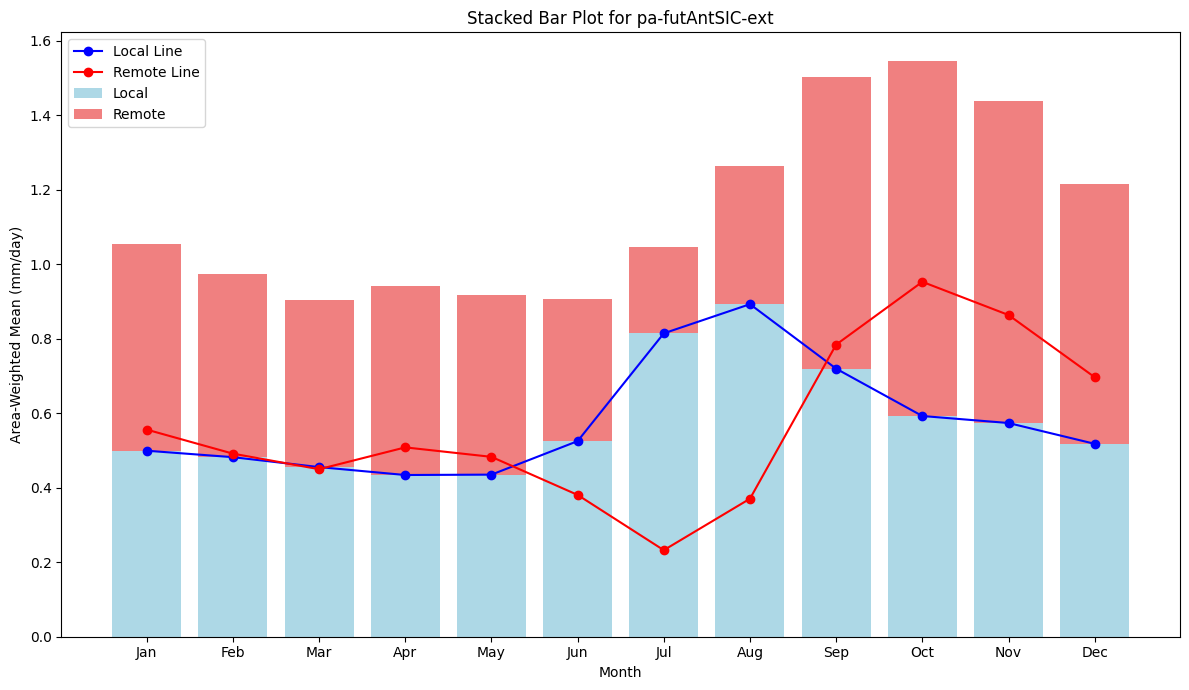

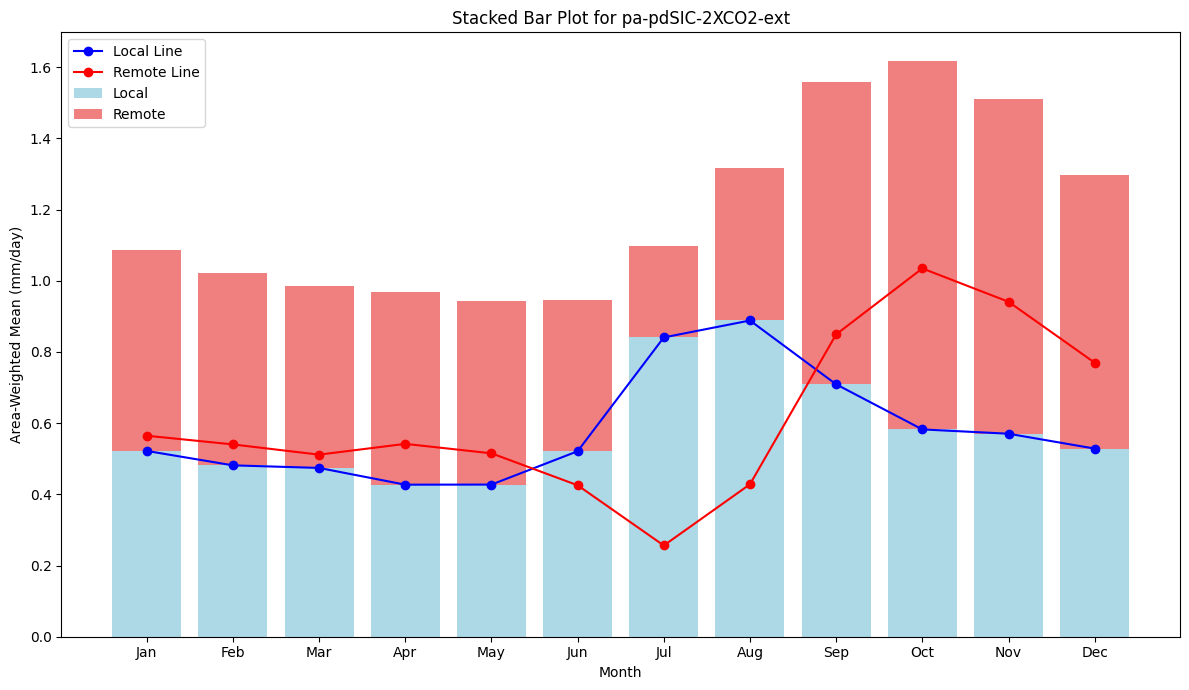

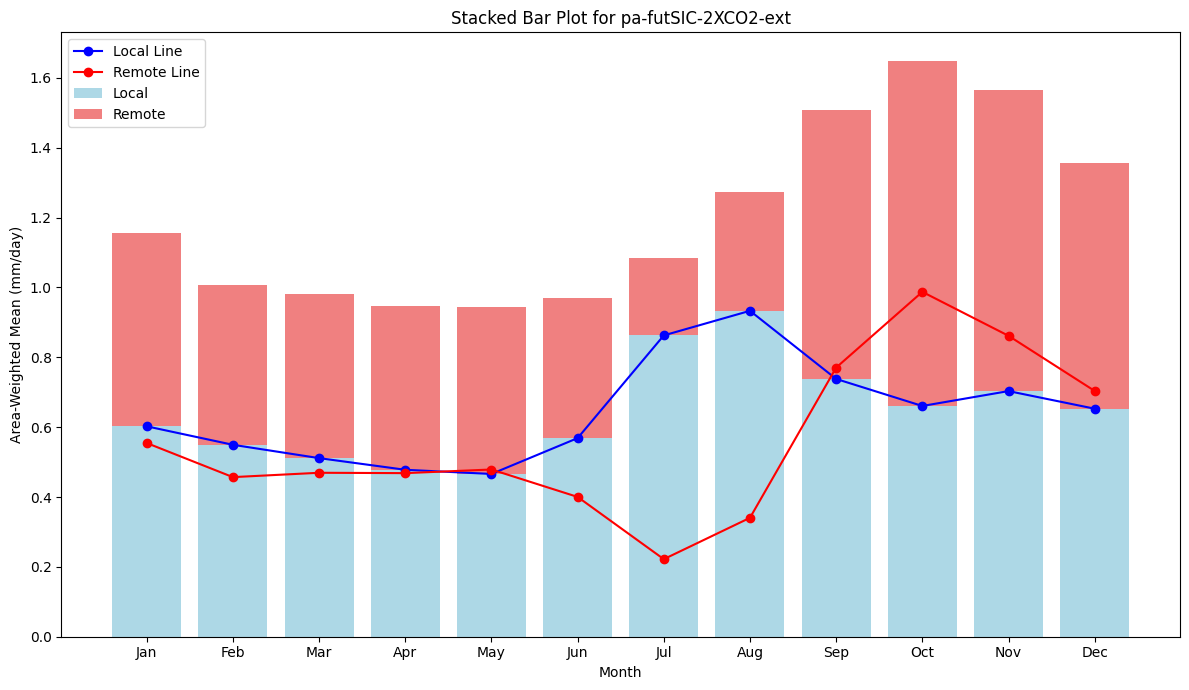

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_stacked_bar_for_experiments(df_qflx, df_transport, scenarios):
    """
    Plots stacked bar plots for each experiment scenario with two lines connecting the tops of the bars.

    Parameters:
    df_qflx (pd.DataFrame): DataFrame with QFLX data.
    df_transport (pd.DataFrame): DataFrame with Transport data.
    scenarios (dict): Dictionary mapping experiment keys to their names.
    """
    months = df_qflx.index

    for scenario_key in df_qflx.columns:
        qflx_data = df_qflx[scenario_key].values
        transport_data = df_transport[scenario_key].values
        
        # Get the scenario name from the dictionary
        scenario_name = scenarios.get(scenario_key, 'Unknown Scenario')
        
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Create stacked bar plot with pastel colors
        bars_qflx = ax.bar(months, qflx_data, color='lightblue', label='Local')
        bars_transport = ax.bar(months, transport_data, color='lightcoral', bottom=qflx_data, label='Remote')

        # Add lines connecting the tops of the bars
        tops_qflx = qflx_data
        tops_transport = qflx_data + transport_data

        ax.plot(months, tops_qflx, color='blue', linestyle='-', marker='o', label='Local Line')
        ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote Line')

        ax.set_xlabel('Month')
        ax.set_ylabel('Area-Weighted Mean (mm/day)')
        ax.set_title(f'Stacked Bar Plot for {scenario_name}')
        ax.set_xticks(months)
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        ax.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

# Convert to DataFrame for plotting
df_qflx, df_transport = to_dataframe(arctic_qflx_datasets_weighted, arctic_transport_datasets_weighted)

# Plot stacked bar plots for each experiment with names
plot_stacked_bar_for_experiments(df_qflx, df_transport, scenarios)

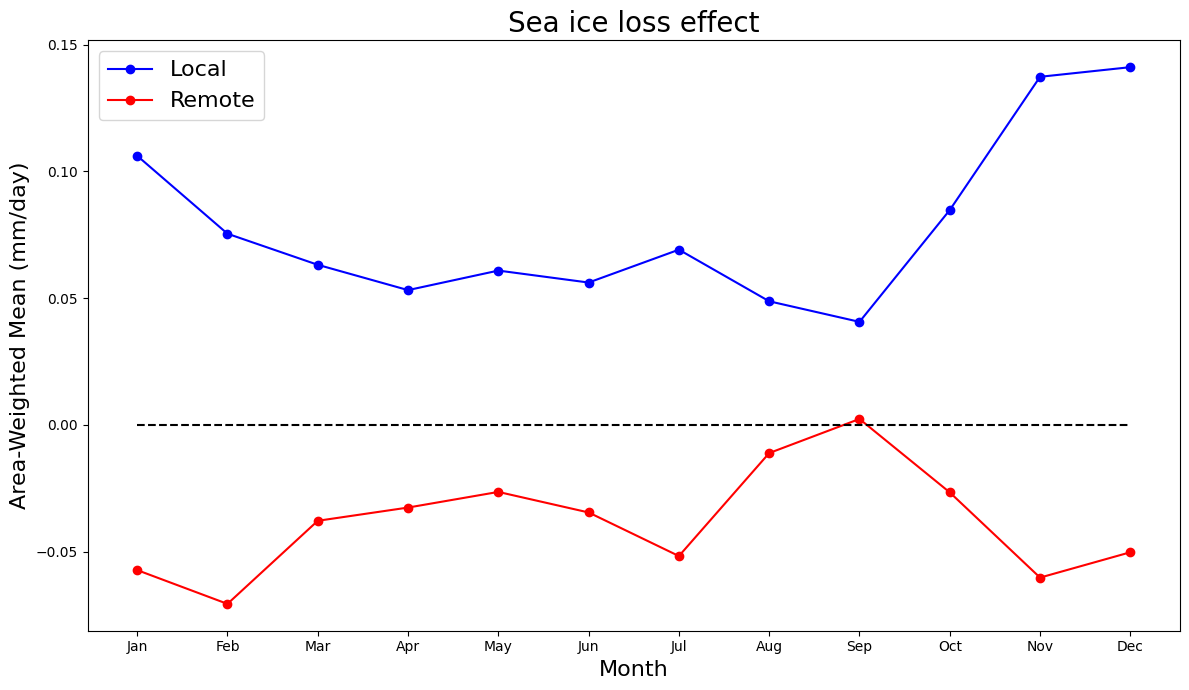

In [14]:
scenario_key1 = 'expt1'
scenario_key2 = 'expt2'

months = df_qflx.index

qflx_data = df_qflx[scenario_key2].values - df_qflx[scenario_key1].values
transport_data = df_transport[scenario_key2].values - df_transport[scenario_key1].values
        
# Get the scenario name from the dictionary
scenario_name = scenarios.get(scenario_key1, 'Unknown Scenario')
        
fig, ax = plt.subplots(figsize=(12, 7))
        
        # Create stacked bar plot with pastel colors
#bars_qflx = ax.bar(months, qflx_data, color='lightblue', label='Local')
#bars_transport = ax.bar(months, transport_data, color='lightcoral', bottom=qflx_data, label='Remote')

# Add lines connecting the tops of the bars
tops_qflx = qflx_data 
tops_transport = qflx_data + transport_data
zero_line = np.zeros_like(months)

ax.plot(months, qflx_data, color='blue', linestyle='-', marker='o', label='Local')
ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote')
ax.plot(months,zero_line, color='black', linestyle='--')


ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Area-Weighted Mean (mm/day)', fontsize=16)
ax.set_title(f'Sea ice loss effect', fontsize=20)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left',  fontsize=16)

plt.tight_layout()
plt.show()

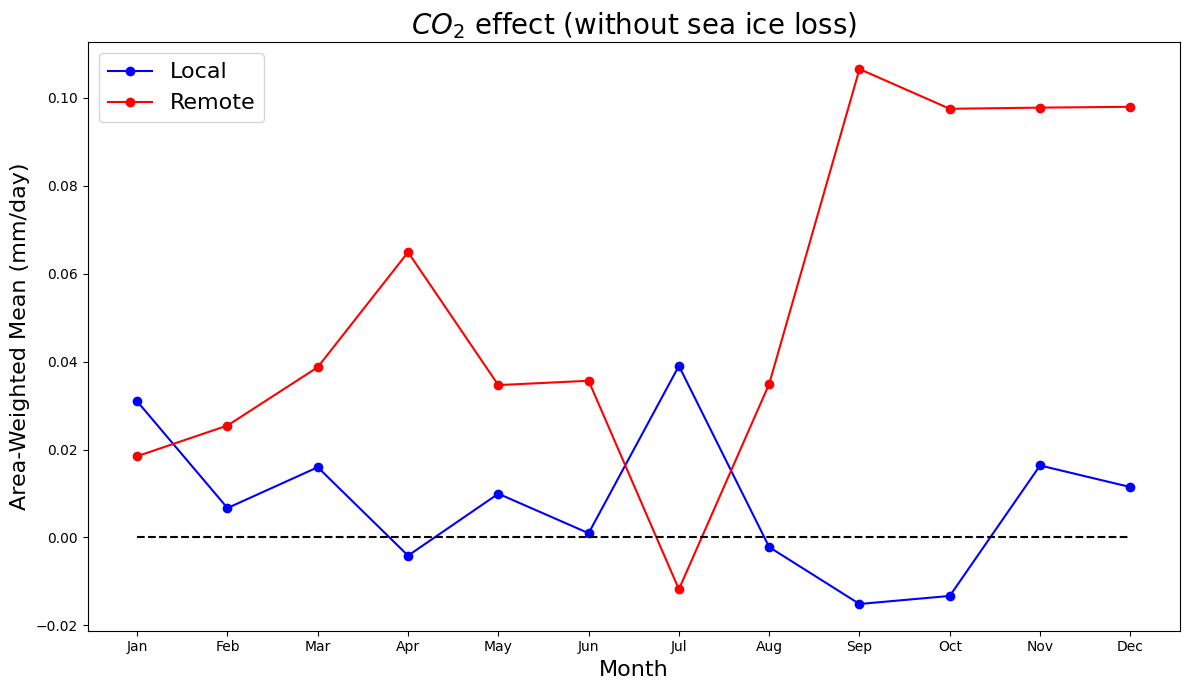

In [19]:
scenario_key1 = 'expt1'
scenario_key2 = 'expt4'

months = df_qflx.index

qflx_data = df_qflx[scenario_key2].values - df_qflx[scenario_key1].values
transport_data = df_transport[scenario_key2].values - df_transport[scenario_key1].values
        
# Get the scenario name from the dictionary
scenario_name = scenarios.get(scenario_key1, 'Unknown Scenario')
        
fig, ax = plt.subplots(figsize=(12, 7))
        
        # Create stacked bar plot with pastel colors
#bars_qflx = ax.bar(months, qflx_data, color='lightblue', label='Local')
#bars_transport = ax.bar(months, transport_data, color='lightcoral', bottom=qflx_data, label='Remote')

# Add lines connecting the tops of the bars
tops_qflx = qflx_data 
tops_transport = qflx_data + transport_data
zero_line = np.zeros_like(months)


ax.plot(months, qflx_data, color='blue', linestyle='-', marker='o', label='Local')
ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote')
ax.plot(months, zero_line, color='black', linestyle='--')


ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Area-Weighted Mean (mm/day)', fontsize=16)
ax.set_title(r'$CO_{2}$ effect (without sea ice loss)', fontsize=20)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left',  fontsize=16)

plt.tight_layout()
plt.show()

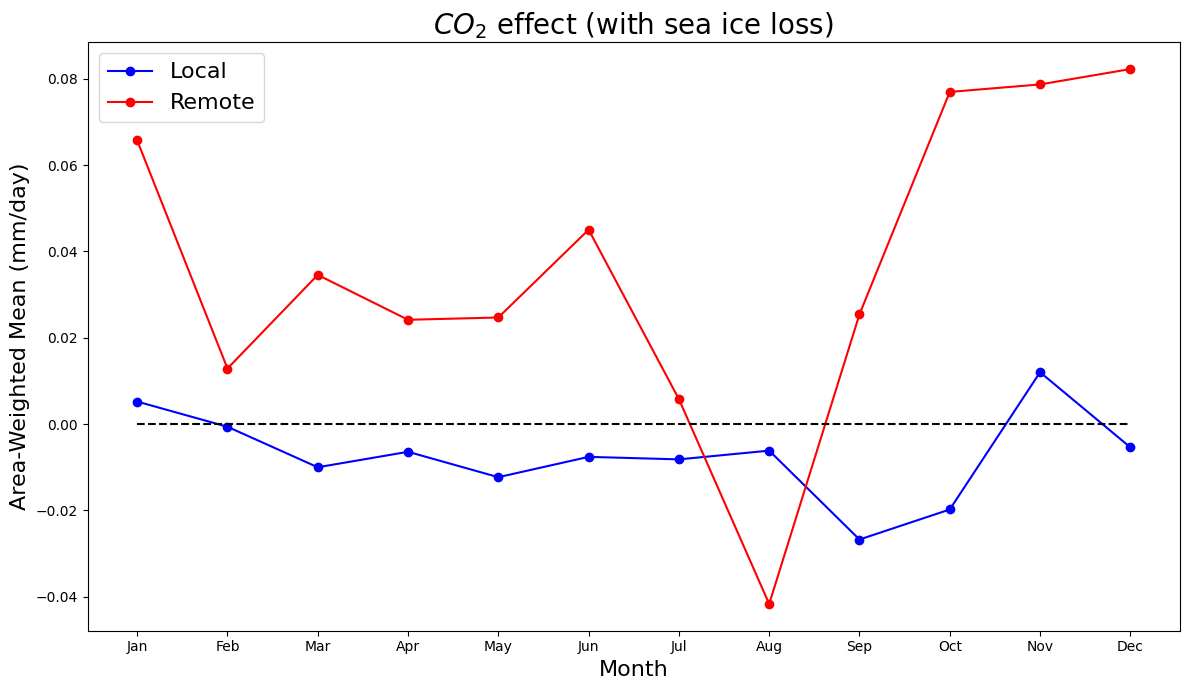

In [18]:
scenario_key1 = 'expt2'
scenario_key2 = 'expt5'

months = df_qflx.index

qflx_data = df_qflx[scenario_key2].values - df_qflx[scenario_key1].values
transport_data = df_transport[scenario_key2].values - df_transport[scenario_key1].values
        
# Get the scenario name from the dictionary
scenario_name = scenarios.get(scenario_key1, 'Unknown Scenario')
        
fig, ax = plt.subplots(figsize=(12, 7))
        
        # Create stacked bar plot with pastel colors
#bars_qflx = ax.bar(months, qflx_data, color='lightblue', label='Local')
#bars_transport = ax.bar(months, transport_data, color='lightcoral', bottom=qflx_data, label='Remote')

# Add lines connecting the tops of the bars
tops_qflx = qflx_data 
tops_transport = qflx_data + transport_data
zero_line = np.zeros_like(months)


ax.plot(months, qflx_data, color='blue', linestyle='-', marker='o', label='Local')
ax.plot(months, transport_data, color='red', linestyle='-', marker='o', label='Remote')
ax.plot(months, zero_line, color='black', linestyle='--')

ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Area-Weighted Mean (mm/day)', fontsize=16)
ax.set_title(r'$CO_{2}$ effect (with sea ice loss)', fontsize=20)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(loc='upper left',  fontsize=16)
plt.tight_layout()
plt.show()